# Natural Computing - Project
#### Submission by group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

The code below uses the DEAP framework (https://github.com/deap/deap), which is a very intuitive framework for evolutionary algorithms and genetic programming.

## Imports

In [1]:
# DEAP
from deap import gp, base, tools, creator, algorithms

# Data processing and plotting
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Requirements for the algorithm
from operator import attrgetter
from functools import partial

# Standard python imports
import random, pickle, math, re, os
import numpy as np

# Magic for inline plots
%matplotlib inline

## Helper functions

In [2]:
def exp(x):
    return np.exp(np.clip(x, -float('inf'), 709.))

In [3]:
def get_avg_height(individual):
    return sum([tree.height for tree in individual])/len(individual)

In [4]:
def print_trees(individual):
    for tree in individual:
        print(f"{tree}\n")

## Global parameters

In [5]:
# Dataset parameters
DATASET = "MNIST" # choose from {"MNIST", "Fashion-MNIST"} 
N_CLASSES_TO_USE = 10 # at most 10

# Individual tree parameters
MAX_ARITY = 10
MIN_INITIAL_HEIGHT = 3
MAX_INITIAL_HEIGHT = 5

HEIGHT_CAPPED = True
MAX_AVG_HEIGHT = 20

# Fitness parameters
SAMPLE_SIZE = 100

# Evolution parameters
N_GENERATIONS = 1000
POPULATION_SIZE = 100

TOURNAMENT_SIZE = 32
SIZE_TOURNAMENT = True
P_SMALLER_WINS = 0.65

P_CROSSOVER = 1.0
P_CROSSOVER_PER_TREE = 1.0

P_MUTATION = 0.3
P_MUTATION_PER_TREE = 0.2
MIN_MUTATION_HEIGHT = 1
MAX_MUTATION_HEIGHT = 3

# Filename parameters
RESULTS_FILENAME = f"DEAP-{DATASET}-results.pkl"

## Loading preprocessed data

In [6]:
# Set the correct data filename
filename = f"{DATASET}-{N_CLASSES_TO_USE}.pkl"

# If the data has not yet been preprocessed in the specified way, do so now
if not os.path.exists(os.path.join("data", filename)):
    print("Preprocessed dataset does not exist yet, creating now.")
    os.system(f"python Preprocessing.py -d {DATASET} -c {N_CLASSES_TO_USE}")

# Load the preprocessed data
with open(os.path.join("data", filename), "rb") as f:
    (X_train, Y_train), (X_test, Y_test) = pickle.load(f)

## Defining operators

In [7]:
# Create set of functions and terminals, with one terminal for each pixel
pset = gp.PrimitiveSet("main", X_train.shape[1])

In [8]:
# Define operators (with a variable number of inputs)
def linear(*args):
    return sum(args)

def step(*args):
    return float(sum(args) > 0)

def sine(*args):
    return np.sin(np.pi*sum(args))

def gaussian(*args):
    return exp(-np.multiply(sum(args), sum(args))/2.0)

def tanh(*args):
    return np.tanh(sum(args))

def sigmoid(*args):
    return (np.tanh(sum(args)/2.0) + 1.0)/2.0

def inverse(*args):
    return -sum(args)

def absolute(*args):
    return abs(sum(args))

def relu(*args):
    return np.maximum(0.0, sum(args))

def cosine(*args):
    return np.cos(np.pi*sum(args))

In [9]:
# Add operators to the set (using a "hacky" solution to allow variable arities)
for arity in range(1, MAX_ARITY+1):
    pset.addPrimitive(linear, arity)
    pset.addPrimitive(step, arity)
    pset.addPrimitive(sine, arity)
    pset.addPrimitive(gaussian, arity)
    pset.addPrimitive(tanh, arity)
    pset.addPrimitive(sigmoid, arity)
    pset.addPrimitive(inverse, arity)
    pset.addPrimitive(absolute, arity)
    pset.addPrimitive(relu, arity)
    pset.addPrimitive(cosine, arity)

## Defining individuals

In [10]:
# Intialize the toolbox which will contain all sorts of functions for the genetic programming process
toolbox = base.Toolbox()

In [11]:
# Define how to create a random expression/tree (using half-and-half intialization)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=MIN_INITIAL_HEIGHT, max_=MAX_INITIAL_HEIGHT)

In [12]:
# Define classes for fitness, trees and individuals (using DEAP's creator module)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Tree", gp.PrimitiveTree)
creator.create("Individual", list, fitness=creator.FitnessMin) # An individual is a list of single-output trees

In [13]:
# Define how to initialize a tree, individual or population
toolbox.register("tree", tools.initIterate, creator.Tree, toolbox.expr)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.tree, N_CLASSES_TO_USE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## Fitness function

In [14]:
# Define how to compile a single tree and an individual
toolbox.register("compile_tree", gp.compile, pset=pset)

In [15]:
# Define how to compile an individual (list of trees)
def compile_individual(individual):
    # Compile all trees in the individual
    funcs = [toolbox.compile_tree(t) for t in individual]
    
    # Create the function, which applies softmax over the outputs of the created lambda functions
    def func(args):
        def _softmax(x):
            return exp(x)/np.sum(exp(x), axis=0)
        return _softmax([f(*args) for f in funcs])
    
    # Return the created function
    return func

In [16]:
# Add compile_individual to toolbox
toolbox.register("compile_individual", compile_individual)

In [17]:
# Define fitness function   
def fitness(individual, sample_size):
    # Compile the individual to obtain the corresponding function
    func = toolbox.compile_individual(individual)
    
    # Define how to compute cross-entropy
    def _cross_entropy(pred, label):
        return -np.log(pred[label])
    
    # Create a list of samples to test, ensuring an equal number of samples from each class
    sample_indices = []
    samples_per_class = int(sample_size/N_CLASSES_TO_USE)
    for c in range(N_CLASSES_TO_USE):
        c_indices = np.where(Y_train == c)[0]
        assert len(c_indices) >= samples_per_class, \
            f"Class {c} has too few elements to reach the desired number of evaluation samples"
        sample_indices.extend(np.random.permutation(c_indices)[:samples_per_class])
    
    # Compute cross-entropy loss for each of the samples
    losses = [_cross_entropy(func(X_train[i]), Y_train[i]) for i in sample_indices]
    
    # Return the average cross-entropy loss
    return (np.average(losses),)

In [18]:
# Add the fitness function to the toolbox
toolbox.register("evaluate", fitness, sample_size=SAMPLE_SIZE)

## Evolution components

##### Parent selection

In [19]:
# Redefine the tools.selDoubleTournament function for our multi-tree individuals (all comments from the 
# original function have been removed to aid readability; the function remains unchanged except for the 
# usage of get_avg_height instead of len (as well as some differences in imports and python version)
def selDoubleTournament(individuals, k, fitness_size, parsimony_size, fitness_first, fit_attr="fitness"):
    assert (1 <= parsimony_size <= 2), "Parsimony tournament size has to be in the range [1, 2]."

    def _sizeTournament(individuals, k, select):
        chosen = []
        for i in range(k):
            prob = parsimony_size / 2.
            ind1, ind2 = select(individuals, k=2)

            # This is the part that matters for our re-implementation: we use the average height of
            # all trees instead of the length of the individual, which is equal for all individuals
            if get_avg_height(ind1) > get_avg_height(ind2):
                ind1, ind2 = ind2, ind1
            elif get_avg_height(ind1) == get_avg_height(ind2):
                prob = 0.5

            chosen.append(ind1 if random.random() < prob else ind2)

        return chosen

    def _fitTournament(individuals, k, select):
        chosen = []
        for i in range(k):
            aspirants = select(individuals, k=fitness_size)
            chosen.append(max(aspirants, key=attrgetter(fit_attr)))
        return chosen

    if fitness_first:
        tfit = partial(_fitTournament, select=tools.selRandom)
        return _sizeTournament(individuals, k, tfit)
    else:
        tsize = partial(_sizeTournament, select=tools.selRandom)
        return _fitTournament(individuals, k, tsize)

In [20]:
# Define how to select parents (either a double tournament that controls for bloat or a single tournament that does not)
if SIZE_TOURNAMENT:
    toolbox.register("select", selDoubleTournament, fitness_size=TOURNAMENT_SIZE, 
                     parsimony_size=P_SMALLER_WINS*2, fitness_first=False)
else:
    toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

##### Crossover

In [21]:
# Define how to perform crossover
def crossover(ind1, ind2):
    new_ind1, new_ind2 = [], []
    for i in range(N_CLASSES_TO_USE):
        tree1, tree2 = ind1[i], ind2[i]
        if np.random.random() < P_CROSSOVER_PER_TREE:
            tree1, tree2 = gp.cxOnePoint(tree1, tree2)
        new_ind1.append(tree1)
        new_ind2.append(tree2)
    return (creator.Individual(new_ind1), creator.Individual(new_ind2))

In [22]:
# Add the crossover ("mate") function to the toolbox
toolbox.register("mate", crossover)

##### Mutation

In [23]:
# Define how to create a "mutation tree"
toolbox.register("expr_mut", gp.genHalfAndHalf, min_=MIN_MUTATION_HEIGHT, max_=MAX_MUTATION_HEIGHT)

In [24]:
# Define how to perform mutation
def mutate(individual):
    new_ind = []
    for tree in individual:
        if np.random.random() < P_MUTATION_PER_TREE:
            new_ind.append(gp.mutUniform(tree, expr=toolbox.expr_mut, pset=pset)[0])
        else:
            new_ind.append(tree)
    return creator.Individual(new_ind),

In [25]:
# Add the mutation ("mutate") function to the toolbox
toolbox.register("mutate", mutate)

##### Height boundary

In [26]:
# Define upper limits for height of trees (if limit is exceeded, a random parent is used instead)
if HEIGHT_CAPPED:
    toolbox.decorate("mate", gp.staticLimit(key=get_avg_height, max_value=MAX_AVG_HEIGHT))
    toolbox.decorate("mutate", gp.staticLimit(key=get_avg_height, max_value=MAX_AVG_HEIGHT))

## Defining statistics

In [27]:
# Describe which kinds of statistics to keep track of
stats_fit = tools.Statistics(key = lambda ind: ind.fitness.values)
stats_height = tools.Statistics(key = get_avg_height)
mstats = tools.MultiStatistics(fitness=stats_fit, height=stats_height)

In [28]:
# Describe metrics to keep track of for each statistic
mstats.register("min", np.min)
mstats.register("avg", np.mean)
mstats.register("std", np.std)

## Running the genetic programming algorithm

##### Running the algorithm

In [ ]:
# Run the evolutionary algorithm
pop = toolbox.population(POPULATION_SIZE)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(population=pop, toolbox=toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION, 
                                     ngen=N_GENERATIONS, stats=mstats, halloffame=hof, verbose=True)

   	      	                fitness                	                 height                 
   	      	---------------------------------------	----------------------------------------
gen	nevals	avg    	gen	min    	nevals	std    	avg  	gen	min	nevals	std     
0  	100   	11.6476	0  	2.42793	100   	7.41897	3.984	0  	3.3	100   	0.254055
1  	100   	2.67183	1  	2.36846	100   	0.314271	4.163	1  	3.7	100   	0.298213
2  	100   	2.46143	2  	2.3503 	100   	0.0393085	4.186	2  	3.5	100   	0.31655 
3  	100   	2.45193	3  	2.37375	100   	0.0379152	4.088	3  	3.6	100   	0.284   
4  	100   	2.45611	4  	2.34905	100   	0.0442653	4.372	4  	3.7	100   	0.33259 
5  	100   	2.4482 	5  	2.34184	100   	0.042413 	4.468	5  	3.8	100   	0.358575
6  	100   	2.42834	6  	2.3341 	100   	0.0374387	4.436	6  	3.7	100   	0.317024
7  	100   	2.41746	7  	2.32979	100   	0.0369191	4.753	7  	4  	100   	0.375088
8  	100   	2.42292	8  	2.3517 	100   	0.0423766	4.917	8  	3.9	100   	0.368797
9  	100   	2.41762	9  	2.31586	100   	0.0

102	100   	2.2473 	102	2.12837	100   	0.0567399	7.42 	102	7.1	100   	0.198494
103	100   	2.23715	103	2.13679	100   	0.0497376	7.363	103	6.7	100   	0.186898
104	100   	2.23991	104	2.14327	100   	0.0630962	7.366	104	7  	100   	0.154415
105	100   	2.24935	105	2.1487 	100   	0.192207 	7.36 	105	6.6	100   	0.153623
106	100   	2.29894	106	2.12544	100   	0.717964 	7.414	106	7.2	100   	0.179455
107	100   	2.22799	107	2.1144 	100   	0.0614218	7.374	107	7  	100   	0.174711
108	100   	2.22131	108	2.12315	100   	0.0530404	7.435	108	7  	100   	0.275817
109	100   	2.24156	109	2.12482	100   	0.092948 	7.387	109	7  	100   	0.23309 
110	100   	2.23994	110	2.12026	100   	0.165412 	7.384	110	7  	100   	0.156665
111	100   	2.22474	111	2.14668	100   	0.0405048	7.431	111	7  	100   	0.181491
112	100   	2.22329	112	2.1353 	100   	0.0459359	7.369	112	6.8	100   	0.204301
113	100   	2.22302	113	2.10484	100   	0.0485757	7.505	113	7  	100   	0.247538
114	100   	2.22661	114	2.12358	100   	0.0575773	7.432	114	7  	10

##### Wrapping up

In [ ]:
# Store results
with open(RESULTS_FILENAME, "wb") as f:
    pickle.dump((pop, log, hof), f)

## Plotting statistics

In [29]:
# Store results
with open(RESULTS_FILENAME, "rb") as f:
    (pop, log, hof) = pickle.load(f)

In [30]:
# Extract generation IDs, minimum fitnesses and average total heights per generation
gen = log.select("gen")
fitness_best = log.chapters["fitness"].select("min") 
height_avg = log.chapters["height"].select("avg")

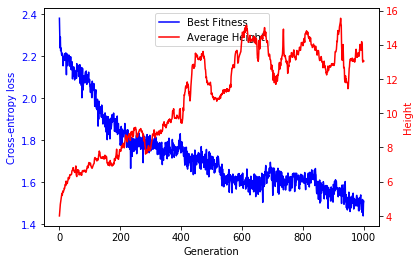

In [31]:
# Plot line for minimum fitness
fig, fit_ax = plt.subplots()
fit_line = fit_ax.plot(gen, fitness_best, "b-", label="Best Fitness")
fit_ax.set_xlabel("Generation")
fit_ax.set_ylabel(f"Cross-entropy loss", color="b")
for tl in fit_ax.get_yticklabels():
    tl.set_color("b")

# Plot line for average total height
height_ax = fit_ax.twinx()
height_line = height_ax.plot(gen, height_avg, "r-", label="Average Height")
height_ax.set_ylabel("Height", color="r")
for tl in height_ax.get_yticklabels():
    tl.set_color("r")

# Add legend
lines = fit_line + height_line
labs = [l.get_label() for l in lines]
fit_ax.legend(lines, labs, loc="upper center")

# Show the result
plt.show()

## Inspecting the best individual

In [32]:
best_ind = hof[0]
print(f"Fitness of best individual: {best_ind.fitness}")

Fitness of best individual: (1.4397484713940247,)


##### Printing trees

In [33]:
# Print the trees of the best individual
print_trees(best_ind)

cosine(tanh(linear(ARG6, ARG235, ARG223, ARG57, ARG138, tanh(relu(cosine(ARG200, ARG138, ARG116), linear(ARG96, ARG104, ARG117, ARG30, ARG107, ARG255, ARG14), relu(ARG85, ARG176, ARG127, ARG164), absolute(ARG150, ARG58, ARG201, ARG194), sigmoid(ARG223, ARG158, ARG197, ARG187, ARG230, ARG179, ARG232), gaussian(ARG61, ARG225, ARG175, ARG242, tanh(linear(ARG139, ARG165, ARG138, ARG47, ARG11, ARG129, ARG114, ARG243), ARG118), ARG78), gaussian(ARG7, ARG197, ARG248, ARG243), cosine(ARG26, ARG236, ARG162, ARG158, ARG185), cosine(ARG77, linear(ARG203), ARG71, ARG75, ARG185, ARG250)), sigmoid(step(ARG186, ARG208, ARG102, ARG175, ARG19), ARG160, tanh(ARG96, ARG242, ARG29, ARG57, ARG1, ARG176, ARG180, ARG105), ARG235), absolute(gaussian(ARG167, ARG204, ARG220, ARG86, ARG68, ARG88, ARG15, ARG60, ARG137, ARG176), cosine(ARG45), inverse(ARG46, ARG109, ARG105, ARG19), step(ARG107, ARG77, ARG215, ARG243), cosine(ARG171, ARG199, ARG80), inverse(ARG98, ARG219, ARG231), inverse(ARG83)), gaussian(tanh(ARG

##### Computing training & validation accuracy

In [34]:
# Retrieving predictions from an individual
def get_predictions(individual, X):
    func = toolbox.compile_individual(individual)
    predictions = []
    for i in range(X.shape[0]):
        predictions.append(np.argmax(func(X[i])))
    return predictions

In [35]:
# Compute accuracy of predictions
def compute_accuracy(Y_pred, Y_true):
    n_correct = np.sum(Y_pred == Y_true)
    return n_correct/Y_true.shape[0]

In [36]:
# Retrieve predictions of the best individual on the training and validation sets
Y_train_pred = get_predictions(best_ind, X_train)
Y_test_pred = get_predictions(best_ind, X_test)

In [37]:
# Print training and validation accuracies of the best individual
print(f"Training accuracy: {compute_accuracy(Y_train_pred, Y_train)}")
print(f"Validation accuracy: {compute_accuracy(Y_test_pred, Y_test)}")

Training accuracy: 0.5116833333333334
Validation accuracy: 0.5194


##### Confusion matrices

In [38]:
# Compute confusion matrices
cm_train = confusion_matrix(Y_train, Y_train_pred, labels=range(N_CLASSES_TO_USE))
cm_test = confusion_matrix(Y_test, Y_test_pred, labels=range(N_CLASSES_TO_USE))

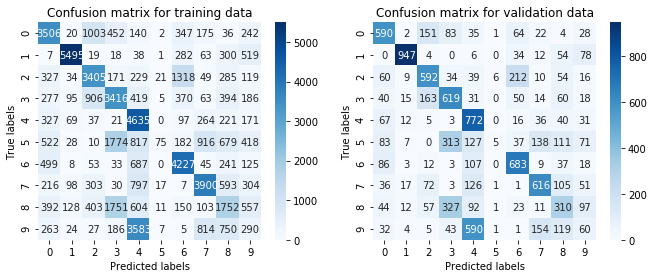

In [42]:
# Create figure
fig, ax = plt.subplots(1,2, figsize=(11,4))

# Plot confusion matrix for training data
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap="Blues")
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[0].set_title('Confusion matrix for training data')

# Plot confusion matrix for validation data
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1], cmap="Blues")
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion matrix for validation data')

# Show the result
plt.savefig('confusion_deap_{}.png'.format(DATASET))
plt.show()

##### Used features

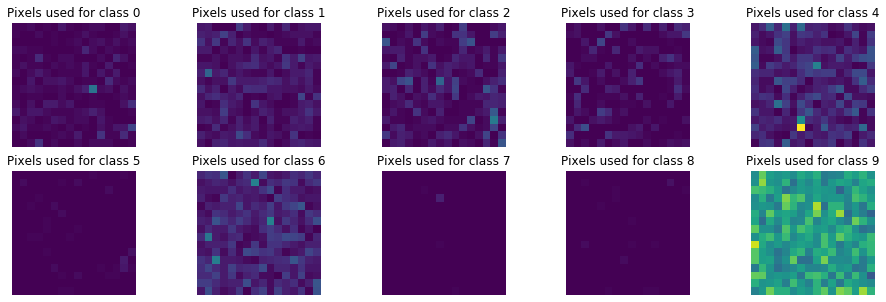

In [43]:
# Extract input tallies from best individual
input_tallies = []
for tree in best_ind:
    inputs_used = list(map(int, re.findall("[0-9]+", str(tree))))
    input_tally = np.zeros(X_train.shape[1])
    for arg in inputs_used:
        input_tally[arg] += 1
    input_tallies.append(input_tally)

# Create plots of the inputs (pixels) used in the tree of the best individual for each class
# Note: for the best-looking plot, this implementation assumes that N_CLASSES_TO_USE is set to 10
fig, ax = plt.subplots(2, 5, figsize=(16,5))
ax = ax.ravel()
for i, tally in enumerate(input_tallies):
    img_shape = int(math.sqrt(X_train.shape[1]))
    ax[i].imshow(np.array(tally).reshape(img_shape, img_shape), clim=(0,np.max(input_tallies)))
    ax[i].axis("off")
    ax[i].set_title(f"Pixels used for class {i}")
plt.show()

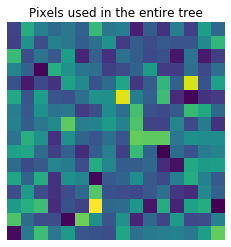

In [44]:
# Plot image of all inputs used in the tree
plt.imshow(np.sum(input_tallies, axis=0).reshape(16,16))
plt.axis("off")
plt.title("Pixels used in the entire tree")
plt.savefig('inputs_deap_{}.png'.format(DATASET))
plt.show()